## EDA

The following EDA is done based on the Xinqian's (03132023) cleansed data set cleaned_listing_df. 

In this data set, two columns neighbourhood_group_cleansed and neighbourhood_cleansed draws our attentions. The former is the higher level category of the latter. So, we want to check how things distribute in each neighbourhood group. Then, we visualize the following three distributions: Fig(1) - Fig(4)

- The distribution of listings in each neighbouhood group
- The distribution of avg price in each neighbourhood group
- The distribution of avg scores in each neighbourhood group

Besides the neighbourhood related features, we want to check some features about the room type and property type. Then, we visualize the following: Fig(5) - Fig(6)

- The distribution of distinct property types in each room type
- The distribution of listings in each room type

Then, how about we combine the neighbourhood features and the room type features to see what we get? 

- The distribution of room type listings in each neighbourhood group

Last, we check the correlation among the following features to see if they correlate each other.

- price
- instant bookable
- have license
- verified host identity
- being a superhost
- the number of reviews received each month

## 0. Import listings dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm
# from langdetect import detect

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

RANDOM_STATE= 42

In [2]:
# check and read the saved data
cleaned_listing_df = pd.read_pickle('../data/data_cleaned/cleaned_listing.zip')
print(cleaned_listing_df.shape)
cleaned_listing_df.head(2)

(4933, 71)


,listing_id,listing_url,last_scraped,listing_name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,has_license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,bathrooms_count,amenities_count,host_response_time_encoded,host_operate_years
0,49113826,https://www.airbnb.com/rooms/49113826,2022-12-24,Private Seattle Getaway Home Near Lake Washing...,A Seattle vacation destination for those from ...,SeaTac International Airport: 14 min drive<br ...,https://a0.muscache.com/pictures/miso/Hosting-...,188538325,https://www.airbnb.com/users/show/188538325,Xiao,2018-05-08,"Seattle, WA",,within an hour,1.0,1.0,1,https://a0.muscache.com/im/pictures/user/32fd3...,Oakland,4,4,"['email', 'phone']",1,1,Rainier View,Rainier Valley,47.510280,-122.246680,Entire home,Entire home/apt,8,4.0,4.0,"[""Hot water"", ""Dining table"", ""Toaster"", ""Refr...",280.0,3,30,3.0,3.0,1125.0,1125.0,3.0,1125.0,1,23,53,83,341,18,7,1,2021-06-22,2022-11-29,4.83,4.89,4.94,4.89,4.89,4.61,4.72,1,0,1,1,0,0,0.98,2.0,53,1,4
1,7455832,https://www.airbnb.com/rooms/7455832,2022-12-24,Classic remodeled in Georgetown,Enjoy your Seattle stay in the vibrant & artis...,Georgetown is a cool neighborhood about three ...,https://a0.muscache.com/pictures/miso/Hosting-...,2144954,https://www.airbnb.com/users/show/2144954,Ryan,2012-04-15,"Seattle, WA",,within an hour,1.0,1.0,0,https://a0.muscache.com/im/pictures/user/a6711...,Greater Duwamish,2,2,"['email', 'phone', 'work_email']",1,0,Georgetown,Other neighborhoods,47.544739,-122.319786,Entire home,Entire home/apt,6,3.0,3.0,"[""Hot water"", ""Crib - available upon request"",...",156.0,1,150,2.0,3.0,1125.0,1125.0,2.1,1125.0,1,17,35,65,329,27,27,3,2022-06-09,2022-12-13,4.89,4.96,4.89,4.93,4.96,4.93,4.93,1,1,2,2,0,0,4.07,2.0,55,1,10


In [3]:
# Create a new dataframe about each neighbourhood group
df_by_neighbourhood = cleaned_listing_df.groupby(['neighbourhood_group_cleansed']).agg(
    {'neighbourhood_cleansed':lambda x: x.nunique(), # Check the number of distinct neighbourhood in each neighbourhood group
    'listing_id':'count', # Check the number of listings in each neighbourhood group
    'host_id':lambda x: x.nunique(), # Check the number of unique hosts in each neighbourhood group
    'price':lambda x: np.round(np.mean(x),1), # Check the avg price of listings in each neighbourhood group
    'review_scores_rating':'mean', # Check the avg various scores in each neighbourhood group
    'review_scores_accuracy':'mean',
    'review_scores_cleanliness':'mean',
    'review_scores_checkin':'mean',
    'review_scores_communication':'mean',
    'review_scores_location':'mean',
    'review_scores_value':'mean'}).round(1).reset_index() 


In [4]:
# extract part of the columns of the new dataframe for purpose of renaming
col_original = list(df_by_neighbourhood.columns)[1:]  

# a list of new names for the extracted columns above
col_new = \
['unique_neighbourhood','number_of_listings','number_of_hosts',
'avg_price','avg_rating','avg_on_accuracy','avg_on_cleanliness',
'avg_on_chekin','avg_on_communication','avg_on_location','avg_on_value']

# rename the columns of the new data frame
for c in range(len(col_original)):
    df_by_neighbourhood.rename(columns = {col_original[c] : col_new[c]}, inplace=True)

# create a new feature for the new column, 
# checking how many listings per host per neighbourhood group on average
    
df_by_neighbourhood['listing_per_host'] = df_by_neighbourhood['number_of_listings']/df_by_neighbourhood['number_of_hosts']


Fig (1) shows the listing distribution of each neighbourhood group. The x-axis represents the different neighbourhood group, the y-axis represents the number of distinct neighbourhoods in the corresponding neighbourhood group, and the size of the scatter points represents the number of listings. So, the bigger the scatter point is, the more listings the corresponding neighbourhood group has. 

Fig (2) shows the average price of each neighbourhood group. The x-axis represents the different neighbourhood group, the y-axis represents the number of distinct neighbourhoods in the corresponding neighbourhood group, and the size of the scatter points represents the average price. So, the bigger the scatter point is, the higher the average price of the listings in the corresponding neighbourhood group is.

Observing Fig (1),  we find the biggest scatter point represents a neighbourhood group called Other neighbourhoods; in other words, this group has the highest number of neighbourhoods and listings. Semantically, it makes sense because the name of this group implies that this group is composed of miscellaneous neighbourhoods. However, since the number of the listings in this group is unproportionately bigger than that of the other groups, it might impact the granularity of the recommendations.

Though the number of listings in each neighbourhood group differs, Fig (2) tells us that the average price of the listings in all the neighbourhood group is similar.

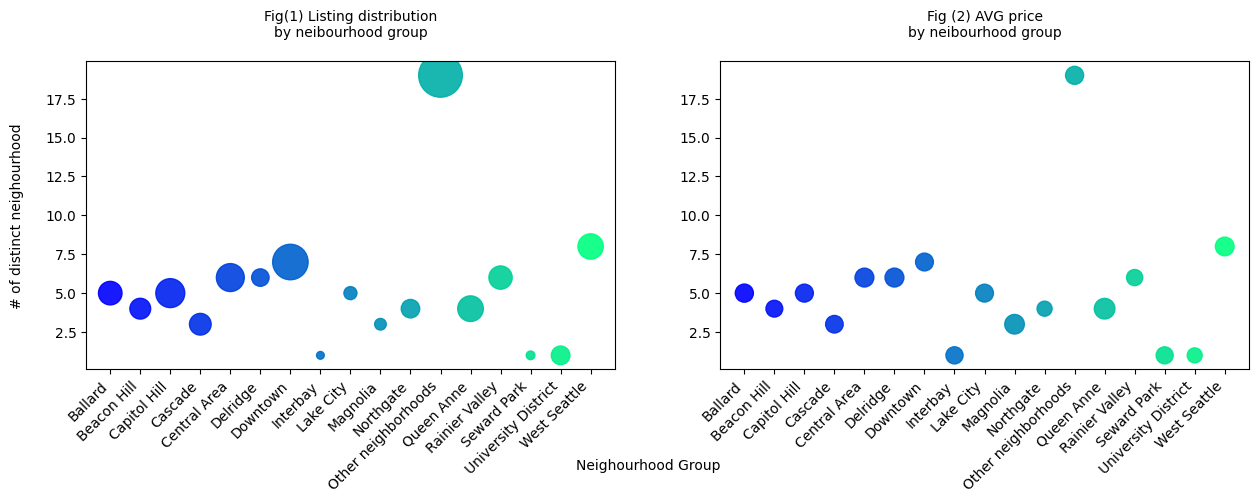

In [5]:
fig, axis = plt.subplots(1, 2, figsize=(15, 4))

x = df_by_neighbourhood['neighbourhood_group_cleansed']
y = df_by_neighbourhood['unique_neighbourhood']
z_a = df_by_neighbourhood['number_of_listings']
z_b = df_by_neighbourhood['avg_price']
colors = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

# Fig (1)
axis[0].scatter(x, y, s=z_a, alpha=0.9, c = colors, cmap ='winter')
axis[0].set_xticklabels(x, rotation = 45, ha ='right')
axis[0].set_ylabel('# of distinct neighourhood\n', fontsize = 10)
axis[0].set_title('Fig(1) Listing distribution\nby neibourhood group\n', fontsize = 10)

# Fig (2)
axis[1].scatter(x, y, s=z_b, alpha=0.9, c = colors, cmap ='winter')
axis[1].set_xticklabels(x, rotation = 45, ha ='right')
axis[1].set_title('Fig (2) AVG price\nby neibourhood group\n', fontsize = 10)

fig.text(0.5, 0.01, '\n\n\n\n\n\n\nNeighourhood Group', ha='center', va='center', fontsize=10)

plt.show()

Then, we want to see how the guests assess the listings in each neighbourhood group. We visualize this intention with line charts. In Fig (3), the x-axis represents the rating dimensions, the y-axis represents the scores, and the lines represents distinct neighbourhood groups. It's found that an outlier is a neighbourhood group called Cascade. The average scores of this group are much lower than the other groups. And, if we check Fig (1) and find Cascade, it's found that this group is bigger than at least other 3 groups (Interbay, Seward Park, and University District). Why its scores are so low? After checking the dataset, it's found there are too many 0 values in the score columns corresponding to this group. Therefore, Fig (3) helps us to find out this outlier.

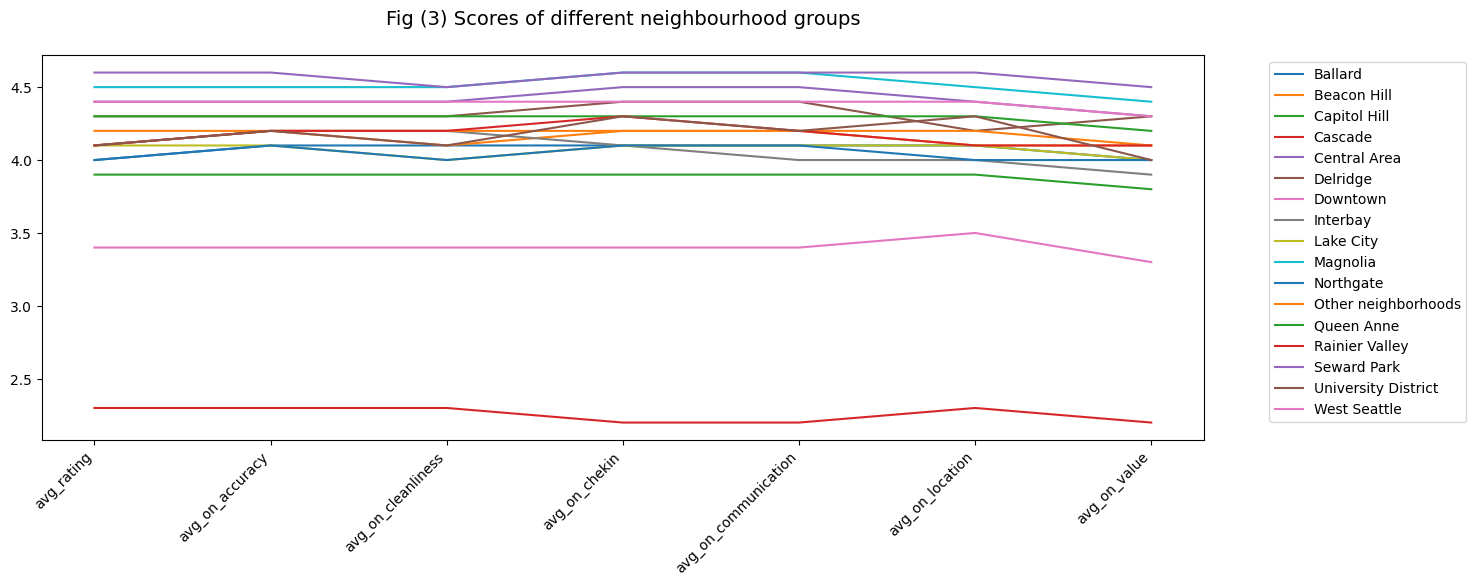

In [6]:
# Fig (3)
plt.figure(figsize=(15,5))
plt.plot(df_by_neighbourhood.iloc[:,5:-1].T)
plt.xticks(rotation = 45, ha ='right')
plt.legend(df_by_neighbourhood['neighbourhood_group_cleansed'],bbox_to_anchor = (1.05,1), loc="best")
plt.title('Fig (3) Scores of different neighbourhood groups\n', fontsize=14)

plt.show()

Then, we check the distribution of each score. As shown in Fig (4-#), all of them contains many 0 values.

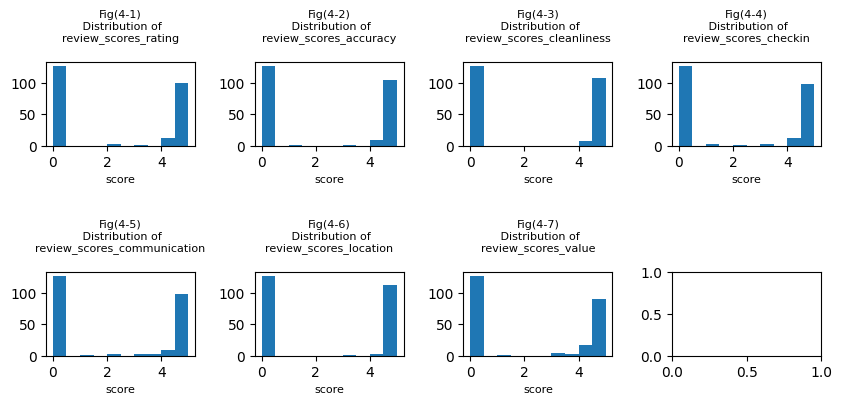

In [7]:
# Fig (4)
scores = ['review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value']

fig, axis = plt.subplots(2, 4, figsize=(10, 3))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)

for i in range(2):
    if i == 0:
        for m in range(4):
            axis[i, m].hist(cleaned_listing_df.loc[cleaned_listing_df['neighbourhood_group_cleansed']=='Cascade'][scores[m]])
            axis[i, m].set_xlabel('score', fontsize = 8)
            axis[i, m].set_title("Fig(4-{})\n Distribution of\n{}\n".format(m+1,scores[m]), fontsize = 8)
    else:
        for n in range(3):
            axis[i, n].hist(cleaned_listing_df.loc[cleaned_listing_df['neighbourhood_group_cleansed']=='Cascade'][scores[4+n]])
            axis[i, n].set_xlabel('score', fontsize = 8)
            axis[i, n].set_title("Fig(4-{})\n Distribution of\n{}\n".format(5+n, scores[4+n]), fontsize = 8)

Now, let's check how room type and property type matter. We first create a new dataframe, showing the number of unique property type, the number of listings, the number of entire room, private rooms and shared rooms by room types.

In [8]:
# extract the following columns to a list
room_type_col = ['host_id'
,"calculated_host_listings_count"  
,"calculated_host_listings_count_entire_homes"    
,"calculated_host_listings_count_private_rooms"   
,"calculated_host_listings_count_shared_rooms"]

# create a new dataframe about the room types
df_by_roomtype = cleaned_listing_df.groupby(['room_type']).agg(
    {'property_type':lambda x: x.nunique(), # unique property type
    room_type_col[1]:sum, # number of listings
    room_type_col[2]:sum, # number of entire homes
    room_type_col[3]:sum, # number of private rooms
    room_type_col[4]:sum })


Starting from the intuition, let's first check how the distinct property types distribute in each room type. Fig (5) shows that most property types are in Entire homes and Private rooms. But, does a room type with a small number of property types also has a small number of listings? With this in mind, we plot Fig (6).

Fig (6) shows the distribution of listings in each room type. We can see that 96% of the listings are in the room type of Entire home/apt, and both shared room and the hotel room have very few listings. This is consistent with Fig (5). However, it's worth our attention that in Fig (5), Private room is a room type with the second most unique property types, and the number of its property type is almost the same as that of the Entire room, but in Fig (6), it's seen that this room type has unproportional listings with the Entire room.

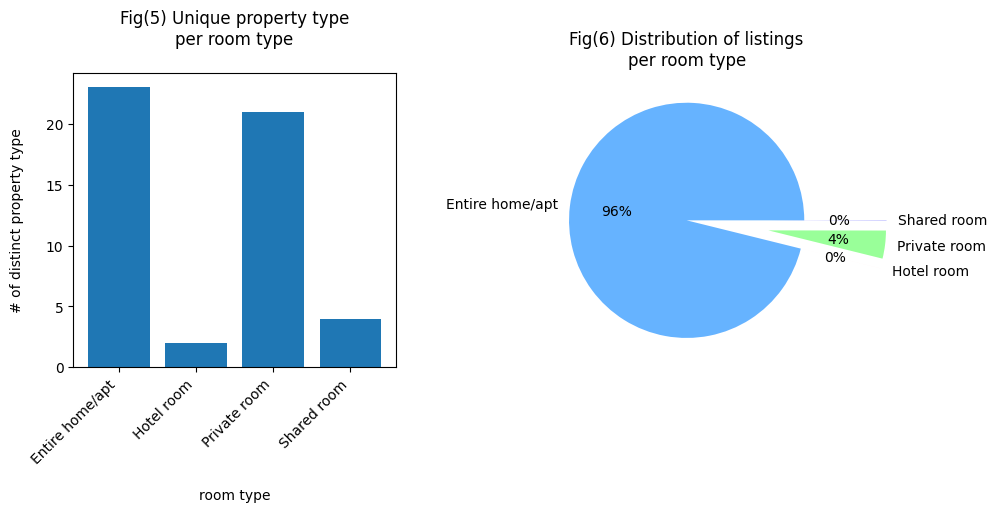

In [9]:
fig, axis = plt.subplots(1, 2, figsize=(10, 3))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)
myexplode = [0, 0.7, 0.7, 0.7]
mycolors = ['#66b3ff','r','#99ff99','b']

for r in range(2):
    if r == 0:
        axis[r].bar(df_by_roomtype.index, df_by_roomtype['property_type'])
        axis[r].set_ylabel('# of distinct property type\n')
        axis[r].set_xlabel('\nroom type')
        axis[r].set_xticklabels(df_by_roomtype.index, rotation = 45, ha ='right')
        axis[r].set_title('Fig(5) Unique property type\nper room type\n')
    else:
        axis[r].pie(df_by_roomtype['calculated_host_listings_count'],labels=df_by_roomtype.index, 
        autopct='%.0f%%', 
        explode = myexplode, colors = mycolors)
        axis[r].set_title('Fig(6) Distribution of listings\nper room type')

plt.show()

Then, we extract data to see how the room types distribute among different neighbourhood groups. Seeing in Fig (7), Downtown has the most listings, and most listings are Entire homes, and most of the private rooms listings are in Capital Hill, Cascade and Other neighbourhood groups.

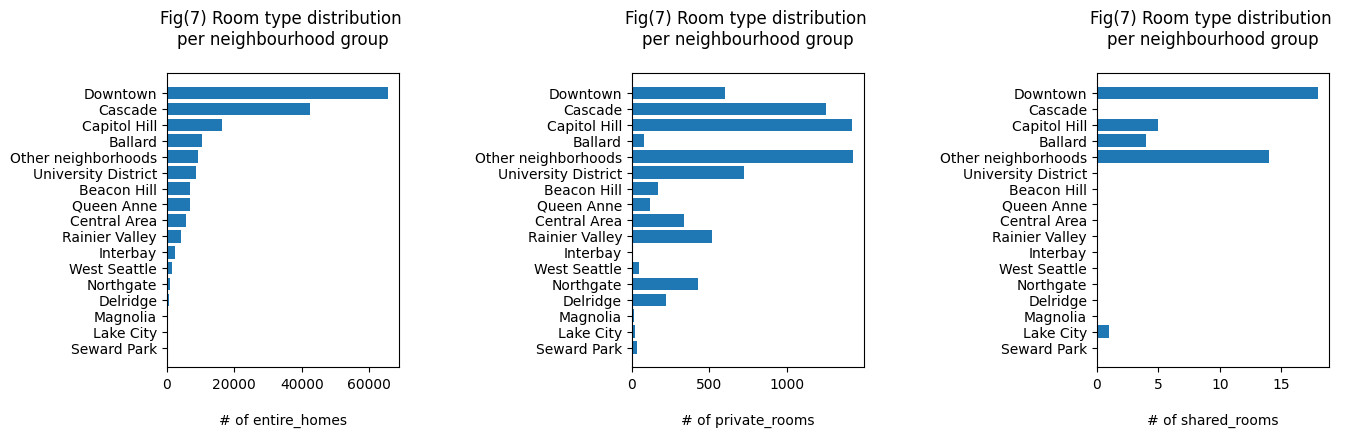

In [10]:
df_room_type_byneighbourhood = cleaned_listing_df.groupby(['neighbourhood_group_cleansed']).agg({room_type_col[2]:sum,
                                                  room_type_col[3]:sum,
                                                  room_type_col[4]:sum}).sort_values('calculated_host_listings_count_entire_homes')


fig, axis = plt.subplots(1, 3, figsize=(15, 3))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=1)
room_type = ['entire_homes','private_rooms','shared_rooms']

for i in range(3):
    axis[i].barh(df_room_type_byneighbourhood.index,df_room_type_byneighbourhood.iloc[:,i])
    axis[i].set_xlabel('\n# of {}'.format(room_type[i]))
    axis[i].set_title('Fig(7) Room type distribution \nper neighbourhood group\n')

plt.show()

In our data set, we also have some True or False features. We encode them as 1 and 0. We wonder if those "credentials" impact the price of the listings.

Fig(8) is a correlation map to show if a host with the following credentials can promote their listings with a higher price:

- instant bookable
- have license
- verified host identity
- being a superhost
- the number of reviews received each month

It's found that having a license is a little bit positive correlated with price, but none of the others impact prices much. But, it's interesting to find that having a license impacts to be a super host and to receive reviews each month.

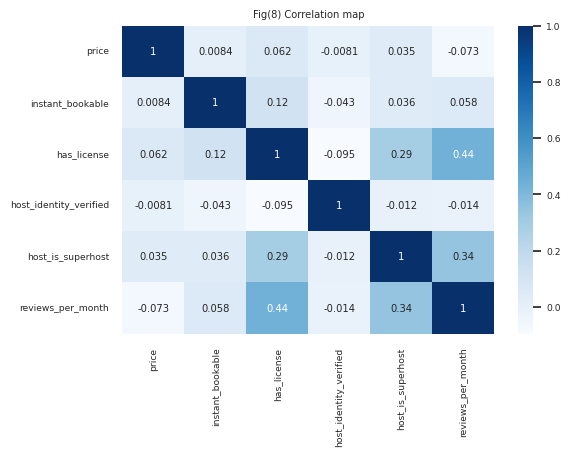

In [11]:
correlation_col = ["price", "instant_bookable", "has_license", "host_identity_verified", 
                   "host_is_superhost", "reviews_per_month"]

df_correlation = cleaned_listing_df[correlation_col]
corr = df_correlation.corr()

plt.figure(figsize=(6, 4))
sns.set(font_scale=0.6)
sns.heatmap(corr, cmap ="Blues", annot = True)
plt.title('Fig(8) Correlation map')

plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f2a50dc6-ff6a-45ff-9dbe-d7a35bd1e393' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>